# Basics [Numba]
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [basics_Numba.ipynb](https://github.com/diegoinacio/computer-vision-notebooks/blob/master/Tips-and-Tricks/basics_Numba.ipynb)
---
Basic functions and operations using [Numba](http://numba.pydata.org/), *NumPy* and *Python*.

In [1]:
import numpy as np

# 0. Installation
---

[Installation](http://numba.pydata.org/numba-doc/latest/user/installing.html) command for *anaconda* and *pip*:

```
$ conda install numba
```

or

```
$ pip install numba
```

In [2]:
import numba

# 1. Jit
---
Jit is the principal and most fundamental Numba's feature. It is a compiler which basically converts a function into efficient machine code.

In [3]:
from numba import jit

For example, given a matrix $M$ which is expected the sum of all elements. In a "Pythonic" way, the probom could be solved by:

In [4]:
def sum_matrix(M):
    N1, N2 = M.shape
    result = 0
    for i in range(N1):
        for j in range(N2):
            result += M[i, j]
    return result

Despite Numpy having a native proper function to get this value, *jit* can converts the function in such as faster as **np.sum**. The procedure is basically to pass the original functions as an argument.

In [5]:
sum_matrix_jit = jit()(sum_matrix)

In [7]:
np.random.seed(1234)
M = np.random.random([int(4e3)]*2)
# Time measurement over the situations
print('{:<14} |'.format('sum_matrix'), end=' ')
%timeit -n 1 -r 3 sum_matrix(M)
print('{:<14} |'.format('np.sum'), end=' ')
%timeit -n 5 -r 10 np.sum(M)
print('{:<14} |'.format('sum_matrix_jit'), end=' ')
%timeit -n 5 -r 10 sum_matrix_jit(M)

sum_matrix     | 3.74 s ± 208 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
np.sum         | 22.6 ms ± 5.49 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
sum_matrix_jit | 17.7 ms ± 5.1 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


## 1.1. Using decorator @jit
---
A common way to work with numba's features is through decorators. The equivalent process to get the function conversion *jit()(sum_matrix)* using decorator would be by:

In [8]:
@jit
def sum_matrix_jit(M):
    N1, N2 = M.shape
    result = 0
    for i in range(N1):
        for j in range(N2):
            result += M[i, j]
    return result

## 1.2. nopython and @njit
---
Run *jit* entirely without the involvement of the Python interpreter. This mode promotes a best performance for loop based functions. For any non numerical situation which python interpreter is important, this mode must be avoided.

In [9]:
from numba import njit

Both decorators **@njit** and **@jit(nopython=True)** are the same.

In [10]:
@njit # or @jit(nopython=True)
def sum_matrix_njit(M):
    N1, N2 = M.shape
    result = 0
    for i in range(N1):
        for j in range(N2):
            result += M[i, j]
    return result

In [13]:
# Time measurement
print('{:<15} |'.format('sum_matrix_jit'), end=' ')
%timeit -n 5 -r 10 sum_matrix_jit(M)
print('{:<15} |'.format('sum_matrix_njit'), end=' ')
%timeit -n 5 -r 10 sum_matrix_njit(M)

sum_matrix_jit  | 17.8 ms ± 3.44 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
sum_matrix_njit | 17.2 ms ± 1.53 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


## 1.3. *parallel* flag and *prange*
---
Jit has a flag which enables the automatic parallelization, and in addition, Numba has implemented the ability to run loops in parallel using *prange*.

In [14]:
from numba import prange

In [15]:
@jit(nopython=True, parallel=True)
def sum_matrix_pjit(M):
    N1, N2 = M.shape
    result = 0
    for i in prange(N1):
        for j in prange(N2):
            result += M[i, j]
    return result

In [17]:
# Time measurement over the situations
print('{:<15} |'.format('sum_matrix_njit'), end=' ')
%timeit -n 5 -r 10 sum_matrix_njit(M)
print('{:<15} |'.format('sum_matrix_pjit'), end=' ')
%timeit -n 5 -r 10 sum_matrix_pjit(M)

sum_matrix_njit | 16.1 ms ± 383 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)
sum_matrix_pjit | 3.95 ms ± 42.6 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)


# 2. Vectorization
---
Functions which operate over array elements.

In [18]:
from numba import void, int64, float64

## 2.1. @vectorize
---
Efficient way to write functions [ufunc](https://docs.scipy.org/doc/numpy/reference/ufuncs.html) which operate over each element of n-dimensional arrays. The auxiliar arguments can be scalar or other arrays which must have the same dims so each element will obey the same order.

In [19]:
from numba import vectorize

The following example calculates the [Greatest Common Factor](https://en.wikipedia.org/wiki/Greatest_common_divisor) between each element pair from the matrices $M_1$ and $M_2$. The "*vectorized*" function operates over the relative elements $x_{1,i}$ and $x_{2,i}$.

In [20]:
@vectorize(
    [int64(int64, int64)],
    target='parallel'
)
def GCF(x1, x2):
    result = 1
    x = min(x1, x2)
    for i in prange(2, x + 1):
        div1 = (x1 % i) == 0
        div2 = (x2 % i) == 0
        if div1 and div2:
            result = i
    return result

In [21]:
N = 1024
np.random.seed(1234)
M1 = np.random.randint(1, 99, (N, N))
M2 = np.random.randint(1, 99, (N, N))
# Time measurement
%timeit -n 5 -r 10 GCF(M1, M2)

48.6 ms ± 320 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [22]:
# Example using 4x30 matrices
np.random.seed(1234)
M1 = np.random.randint(1, 99, (4, 30))
M2 = np.random.randint(1, 99, (4, 30))
# Visualize tables
np.set_printoptions(linewidth=125)
print(M1, end=' M1\n\n')
print(M2, end=' M2\n\n')
print(GCF(M1, M2), end=' GCF')

[[48 84 39 54 77 25 16 50 24 27 31 44 31 27 59 93 70 81 74 48 51 77 38 35 39 68 12  1 76 81]
 [ 4  3 20 13 66 76 82 15 72 61 47 29 82 88 14 97 13 70 96 32 90 85 46 17 42 73 57 71 57 87]
 [45 91 84 48 50 19 86 47 38 39  8 68  6 48 48 16 35 11 29  5 83 90 56 79 24 51 63 56 85  1]
 [91 34 22 72 69 82 53 65 86 42  2 15  4 31 13 74 20 27 97 69 65 23 57 85  9 45 25 95 16 73]] M1

[[ 3 17  3 80 68 47 58 56 37 89 34 43  3 88 85 36 19 77 70 82 81  9 76 16 21 17 65 62 97 84]
 [58 50 63 58 84 28 88 36 37 85 62 29  2 12 63 18 31 39 26 57 25 13 77 97  9 48 88 26 22 23]
 [46 20 42 48 37 40 18 40 60 83 38 88 39  9 55 18 42 48 20 44 45 36 43 21 27 90 24  3 66 90]
 [28 79 69 92 61  4 82 48 62 64 33 14 57 49 59 95 36 58 61 84 10 61 51 52 50 72 82  5  4 89]] M2

[[ 3  1  3  2  1  1  2  2  1  1  1  1  1  1  1  3  1  1  2  2  3  1 38  1  3 17  1  1  1  3]
 [ 2  1  1  1  6  4  2  3  1  1  1 29  2  4  7  1  1  1  2  1  5  1  1  1  3  1  1  1  1  1]
 [ 1  1 42 48  1  1  2  1  2  1  2  4  3  3  1  2  7  1  1  

## 2.2. @guvectorize
---
Similar to *@vectorize* but operates over arbitrary number of elements of input arrays. One difference is the function doesn't necessarily return a value. Instead, it can take the result as an argument. At its declaration, the function's layout is defined in symbolic form like *'(m,n),(),()->(m)'*, where the first argument '*(m,n)*' is and array with dimensions **m**x**n**, the following two arguments '*()*' are scalar or one-element array and the last argument '*(m)*' is the output, which is an array with size **m**.

In [23]:
from numba import guvectorize

The following example calculates the *density* of a point based on the tridimensional distances from the other points. The input **P** is a list of *n* 3D coordinates and the output **R** is an array of densities of the points.

In [24]:
@guvectorize(
    [void(
        float64[:,:],
        int64,
        float64,
        float64[:]
    )],
    '(n,m),(),()->(n)'
)
def density(P, N, r, R):
    for i in prange(N):
        x, y, z = P[i]
        for j in prange(i + 1, N):
            if i == j:
                continue
            u, v, w = P[j]
            dx = abs(x - u)
            if dx > r:
                continue
            dy = abs(y - v)
            if dy > r:
                continue
            dz = abs(z - w)
            if dz > r:
                continue
            d = (dx**2 + dy**2 + dz**2)**0.5
            R[i] += 1 - d/(3*r*r)**0.5
            R[j] += 1 - d/(3*r*r)**0.5

In [25]:
N = 2500
np.random.seed(1234)
# Gaussian mixture
P = np.vstack((
    np.random.normal((-3,0,0), 1.8, (N, 3))*(1, 1, 1/10),
    np.random.normal((0,4,0), 1.4, (N, 3))*(1, 1, 1/10),
    np.random.normal((3,0,0), 1.0, (N, 3))*(1, 1, 1/10)
))
# Output array
R = np.zeros(3*N)
# Time measurement
%time D = density(P, 3*N, 0.75, R)

Wall time: 103 ms


In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

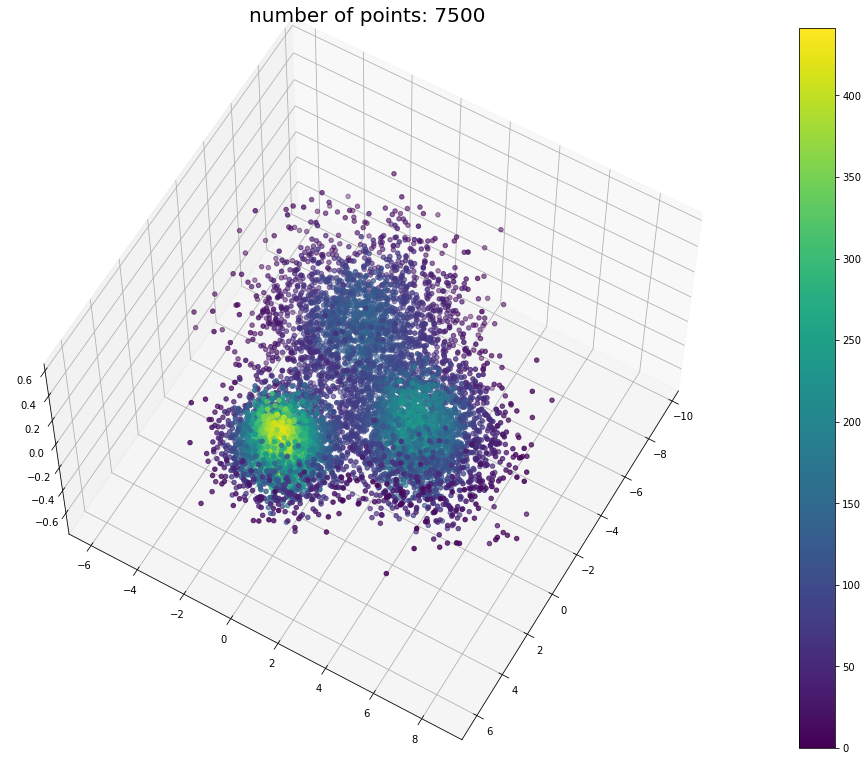

In [27]:
fig = plt.figure(figsize=(20, 10))
ax = Axes3D(fig)
ax.view_init(elev=60, azim=30)
# Visualize points
sct = ax.scatter(*P.T[:3], s=20, c=D)
ax.set_title('number of points: ' + str(3*N), size=20)
plt.colorbar(sct)
plt.show()

# 3. Stencil
---
Efficient way to create stencil kernels. Similarly to *vectorization*, it operates over elements but with the possibility of moving around the element's neighborhood.

In [28]:
from numba import stencil

Stencil promotes a very convenient way to produce spatial filtering for image processing.

In [30]:
from imageio import imread
M = imread('../_data/tomography.png')

## 3.1. Box Filter
---
The [box filter](https://en.wikipedia.org/wiki/Box_blur) results in the average value from the kernel defined by each pixel's neighborhood. The following example shows the box filtering with a kernel 7x7.


In [31]:
# Box Filter 7x7
@stencil(
    neighborhood=(
        (-3, 3),
        (-3, 3)
    ))
def box_filter(M):
    output = 0
    for i in range(-3, 4):
        for j in range(-3, 4):
            output += M[i, j]
    return output/49

In [32]:
%time Mb = box_filter(M)

Wall time: 237 ms


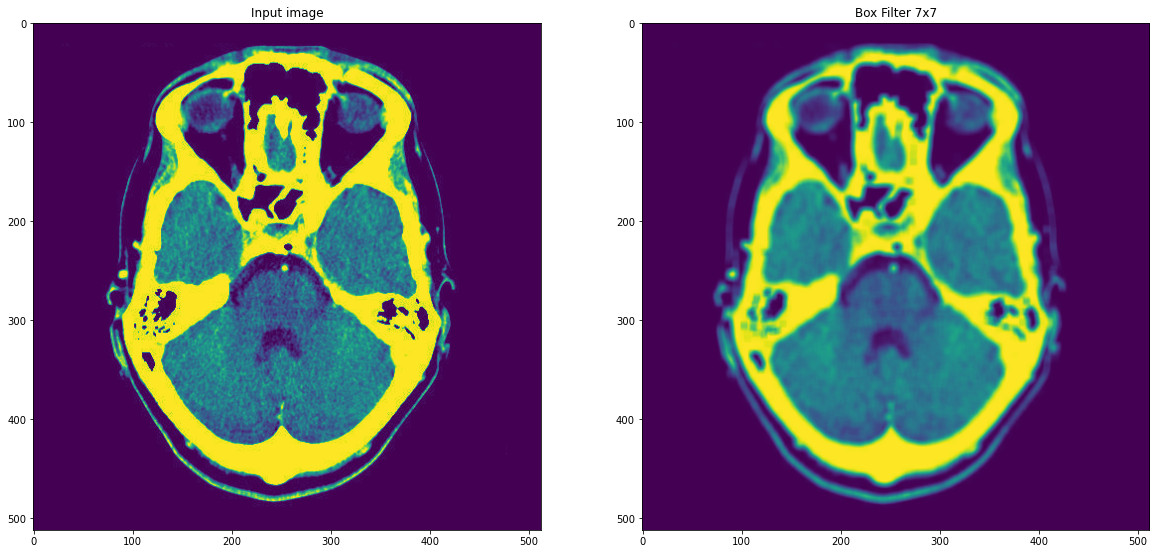

In [33]:
fig, (axA, axB) = plt.subplots(1, 2, figsize=(20, 10))
# Plot images
axA.imshow(M)
axA.set_title('Input image')
axB.imshow(Mb)
axB.set_title('Box Filter 7x7')

plt.show()

## 3.2. Parameterized *box filter*
---
Box filter parameterized by radius $r$, which results in a kernel with diameter $2r + 1$.

In [34]:
def pbox_filter(M, r):
    @stencil(neighborhood=(
        (-r, r),
        (-r, r)
    ))
    def box_filter(M):
        output = 0
        for i in range(-r, r + 1):
            for j in range(-r, r + 1):
                output += M[i, j]
        return output/(2*r + 1)**2
    return box_filter(M)

In [35]:
# Init parameters
rA = 2
rB = 9
# Run box filters
%time MpA = pbox_filter(M, rA)
%time MpB = pbox_filter(M, rB)

Wall time: 387 ms
Wall time: 451 ms


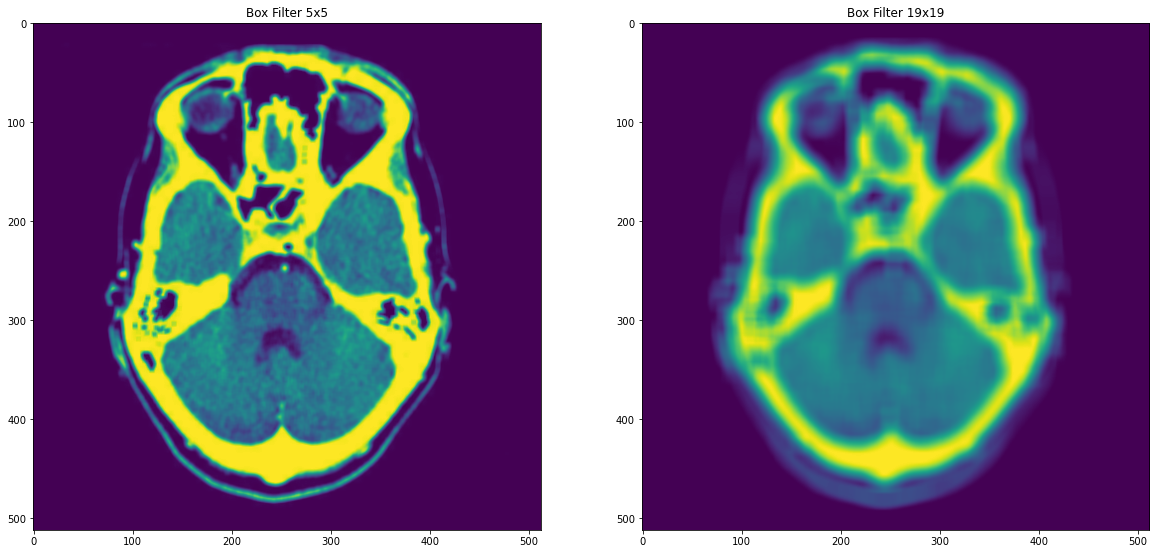

In [36]:
fig, (axA, axB) = plt.subplots(1, 2, figsize=(20, 10))
# Plot images
axA.imshow(MpA)
axA.set_title('Box Filter {0}x{0}'.format(rA*2 + 1))
axB.imshow(MpB)
axB.set_title('Box Filter {0}x{0}'.format(rB*2 + 1))

plt.show()